# Deep Feature Extraction 

In this report, I will explore different ways of extracting, analyzing and classifying slice deep feature results, in order to evaluate fibrosis presence in individual slices.
This notebook contains every optimization and change made up until `aggregateProbabilities.ipynb`. 

In [60]:
# ------------ Utils ------------

from featureUtils import * 

# ---------- Distances ----------

from scipy.spatial.distance import mahalanobis
from sklearn.covariance import LedoitWolf
import torch.nn.functional as F
from numpy.linalg import inv
import math

# ------------ t-SNE ------------

from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE


print(f"Device: {torch.cuda.get_device_name(0)}")

Device: NVIDIA GeForce RTX 3070


In [61]:
# Loads the dataframe
df_fibrosis = pd.read_pickle(r'..\..\..\\fibrosis_data.pkl')
df_annotations = df_fibrosis.drop(columns="SliceData")
df_annotations["SliceID"] = df_annotations["SliceID"].astype(str) + ".npy" # better for data loader
df_annotations.head()

,SliceID,Class
0,101__CT-0002-0001.npy,0
1,101__CT-0002-0002.npy,0
2,101__CT-0002-0003.npy,0
3,101__CT-0002-0004.npy,0
4,101__CT-0002-0005.npy,0


## Training

In [62]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        slice_id = self.img_labels.iloc[idx, 0]
        patient_id = getPatientID(slice_id)

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Already has resize prior to augments
        if self.albumentations:
            stacked_aug = self.albumentations(image=image)
            image = stacked_aug['image']

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)

        return image, label, patient_id


In [63]:
# Paths
img_dir = r'..\..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_test = r"..\trainTestCustom\test.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Augmentations
augment = A.Compose([
    # Applies resize prior to augmentations
    # Could hinder scan quality, but drastically improves training speed
    A.Resize(224, 224),
    # Rotate
    A.Rotate(limit=(-350,30), p=0.8),
    # Translate
    A.Affine(translate_percent={"x":(-0.15,0.15), "y":{-0.23,0.25}},
              rotate=0, scale=1, p=0.8),
    # Shear
    A.Affine(shear={"x":(-15,15), "y":(-15,15)},p=0.8)
])

# Randomized Gaussian Noise and Blur
gauss = True

# Create Datasets

# Using augmentations in a single section (for example, only in training) affects 
# the way the ResNet changes weights and derives features, creating 
# cluster separation in t-SNE data. I'm disabling it for that reason. 
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform) #, albumentations=augment, gauss=gauss)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

In [64]:
models_path = "..\\..\\..\\trainedResNets\\aggregateProb\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    resnet_eval, best_epoch, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

elif ans == "read":
    """
    # Setup ResNet for Reading
    resnet_eval = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    

    # Use only 2 output neurons
    num_ftrs = resnet_eval.fc.in_features
    resnet_eval.fc = nn.Linear(num_ftrs, 2)

    # Load weights
    resnet_eval.load_state_dict(checkpoint['model_state_dict'])

    """

    # Read file
    checkpoint = torch.load(os.path.join(models_path,"metadata.pt"))

    # Load values
    best_epoch = checkpoint["epoch"]
    custom_loss = checkpoint["train_loss"]
    custom_val_loss = checkpoint["val_loss"]

    resnet_eval = torch.load((f"{models_path}"+"resnet_aggregate_correct_val_NOAUG_FEATURES_RUN.pkl"))


else: print("Invalid answer, try again.")

C:\Users\hasht\AppData\Local\Temp\ipykernel_16444\1783186208.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(models_path,"metadata.

In [65]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    torch.save({
    'epoch': best_epoch,
    'train_loss': custom_loss,
    'val_loss': custom_val_loss
}, os.path.join(models_path, 'metadata_NOAUG_FEAtURES.pt'))
    
    torch.save(resnet_eval, (f"{models_path}"+"resnet_aggregate_correct_val_NOAUG_FEATURES_RUN.pkl"))

else: print("DID NOT SAVE")

DID NOT SAVE


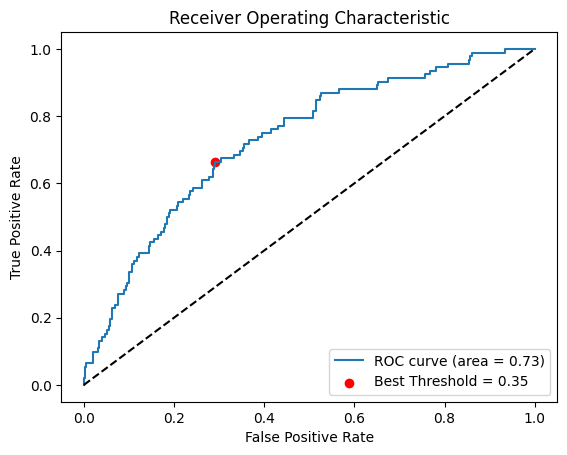

Area Under Curve: 0.7306503772906935
Best Threshold (closest to (0,1)): 0.3493302


In [66]:
threshold_eval, auc_eval = getROC(resnet_eval, val_dataset)

# Feature-wise Classification

This will be done through aggregation of the features determined by the final resnet conv layer, for each slice.

My plan is to create:
 - a dictionary containing keys as "PatientID" and values as arrays of features. 
 - another dictionary containing the same keys, but with features derived from the test split.

### <span style = "color:red"> WARNING  </span>

This concept would force me to re-define the best threshold, as the one obtained in the previous notebook was meant for probability-wise aggregation. So, a new individual best_threshold would need to be determined for each aggregation criteria.

However, this is not nearly as easily obtainable as the best classification threshold for probabilites derived by ROC. In this case, I must first visualize the data I'm working with, regarding features. Only then can I search for aggregation methods, and ways to derive the best parameters for each of the techniques.

The first attempt at implementation was the following:

```py

class ResNetFeat(ResNet):
    def _forward_impl_feat(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

```

However, due to framework issues, I decided to abandom this, and focus on working with **hooks**.

## Creating hooks

The first step to work on this concept requires "hooking" onto the last block's convolutional layer. This allows me to pull the derived features, instead of obtaining a simple logit/prob/class output.


In [67]:
# Loads the model
resnet18_example = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = resnet18_example.fc.in_features
resnet18_example.fc = nn.Linear(num_ftrs, 2)  

# Visulization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_example.to(device)
summary(resnet18_example, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Or, in a more in-depth look at the network's final block (taken from `3.1 - introAndSetup`):

```md

(layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=2, bias=True)
)

```

A hook is a powerful tool that allows for the execution of code during forward or backward passes. If I intercept the final forward pass to the **fully connected** (fc) layer, I'm able to extract the features.

For this implementation, I will be using an adaptation of [this StackOverflow user](https://stackoverflow.com/questions/78279823/how-exactly-the-forward-and-backward-hooks-work-in-pytorch):

In [68]:
class HookFC:
    def __init__(self, model, layer='avgpool'):
        self.model = model
        self.intercepts = []
        self.hook = None

        # Register and save hook
        for name, module in self.model.named_modules():
            if layer in name: self.hook = module.register_forward_hook(self.getLayerOutput)

    def getLayerOutput(self, module, input, output):
        # Clear previous outputs on each forward pass → prevents accumulation
        self.intercepts = [output.detach().cpu()]

    def __call__(self, input_tensor):
        self.model.zero_grad()
        _ = self.model(input_tensor)
        return self.intercepts[0]  # Returns only the latest output

    def remove(self):
        if self.hook is not None:
            self.hook.remove()
            self.hook = None

However, replacing the fully connected layer with torch.nn.Identity also works perfectly fine. This returns the last pooled vector, avoiding transformation to 2 logits, and also returns a result with higher floating point precision.

The implementation above will be preserved, as it represents a more customizable version of this concept.

## Pulling Features

In [69]:
def getFeatures(resnet18, train_dataset, val_dataset, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Used for initial t-SNE
    tsne_features, tsne_labels = [], []

    # Evaluation task data
    eval_features, eval_labels = [], []

    #resnet18.fc = torch.nn.Identity()
    hook = HookFC(resnet18)

    # This loop populates dictionaries with features pulled from the train_dataset
    # using interceptions made by the model hook
    with torch.no_grad():
        for images, labels, patient_id in tqdm(train_loader, desc="Populating training features..."):
            images, labels = images.to(device), labels.to(device)

            #outputs = resnet18(images)
            outputs = hook(images)

            # Associate features to labels
            for ftr, label in zip(outputs, labels.tolist()):
                tsne_features.append(ftr.cpu())  # Adds feature to list
                tsne_labels.append(label)

    
    # Same concept, but for validation_dataset
    with torch.no_grad():
        for images, labels, patient_id in tqdm(val_loader, desc="Populating validation features..."):
            images, labels = images.to(device), labels.to(device)

            outputs = hook(images)

            # Associate features and labels
            for ftr, label in zip(outputs, labels.tolist()):
                tsne_features.append(ftr.cpu())  # Adds feature to list
                tsne_labels.append(label)

    # Same concept, but for test_dataset
    with torch.no_grad():
        for images, labels, patient_id in tqdm(test_loader, desc="Populating test features..."):
            images, labels = images.to(device), labels.to(device)

            outputs = hook(images)

            # Associate features and labels
            for ftr, label in zip(outputs, labels.tolist()):
                eval_features.append(ftr.cpu())  # Adds feature to list
                eval_labels.append(label)
    
    return tsne_features, tsne_labels, eval_features, eval_labels

In [70]:
features, labels, test_features, test_labels = getFeatures(resnet_eval, train_dataset, val_dataset, test_dataset)

Populating test features...: 100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


In [71]:
print(len(features), "slices of shape",(features[0]).shape,"for training + validation")
print(len(test_features),"slices of shape", test_features[0].shape, "for test")

2427 slices of shape torch.Size([512, 1, 1]) for training + validation
648 slices of shape torch.Size([512, 1, 1]) for test


The `torch.Size([512, 1, 1])` shape is essentially `([Features, 1, 1])`:
 - **Features**: Number of channels, which is 512 in this case, and represents each feature
 - **1, 1**: Illustrates the spatial resolution being pooled down to a single value, **1*1**

## t-SNE

t-SNE expects shape `(SampleNumber, Dimension)` for **X**, which in this case will be something like `(N, D)` → each element of **X** must be of shape `(512,)`.

This means that I'll have to transform the tensor, containing 512 elements structured like **`[ [[element1]] , ..., [[element512]] ]`** into a single list with **`[element1, ..., element512]`** structure, representing each derived feature's value for the slice in question.

The best way to do this is through the use of the `.squeeze(-1)` function, which keeps the list order and removes the array around each element. Since each element is wrapped in 2 arrays:

In [72]:
features_reshaped, test_reshaped = [], []

# Each ftr is now (512,)
[features_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in features] 
[test_reshaped.append(ftr.squeeze(-1).squeeze(-1)) for ftr in test_features] 


# For visualization purposes
print('--------------------------------------------------------------')
print("Number of slices with derived features: ", len(features_reshaped))
print("Number of total train + validation slices: ", len(train_dataset) + len(val_dataset))
print("Slice features shape: ",features_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", features_reshaped[0][:5])
print('--------------------------------------------------------------')
print("Number of test slices with derived features: ", len(test_reshaped))
print("Number of total test slices: ", len(test_dataset))
print("Slice features shape: ",test_reshaped[0].shape)
print("First 5 feature values for the first slice: \n    ", test_reshaped[0][:5])
print('--------------------------------------------------------------')

--------------------------------------------------------------
Number of slices with derived features:  2427
Number of total train + validation slices:  2427
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([1.4199, 0.4646, 0.2354, 1.1844, 0.1403])
--------------------------------------------------------------
Number of test slices with derived features:  648
Number of total test slices:  648
Slice features shape:  torch.Size([512])
First 5 feature values for the first slice: 
     tensor([0.0197, 0.6862, 0.1496, 0.7737, 0.5836])
--------------------------------------------------------------


In [73]:
def plotTSNE(train_val_features, train_val_labels, test_features=None, apply_pca=False):
    X_train_val = torch.stack(train_val_features).cpu().numpy()
    y_train_val = np.array(train_val_labels)

    if test_features:
        # Associate to label == 2 

        X_test = torch.stack([f.view(-1) for f in test_features], dim=0).cpu().numpy()
        y_test = np.full(len(X_test), 2) 
         
        # Combine for joint t-SNE
        X = np.concatenate((X_train_val, X_test), axis=0)
        y = np.concatenate((y_train_val, y_test), axis=0)
    
    else: X, y = X_train_val, y_train_val
        
    if apply_pca:
        pca = PCA(n_components=50)
        X = pca.fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    # Assign colors
    colors = np.array([
        'green' if label == 0 else
        'red' if label == 1 else
        'blue' for label in y
    ])

    plt.figure(figsize=(10, 8))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=10)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0', markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='red', markersize=8)
    ]
    
    if test_features: legend_elements.append(Line2D([0], [0], marker='o', 
                                            color='w', label='Test', 
                                            markerfacecolor='blue', markersize=8))

    plt.legend(handles=legend_elements, title="Classes")
    plt.title("t-SNE of ResNet Features (with PCA)" if apply_pca else "t-SNE of ResNet Features")
    plt.show()


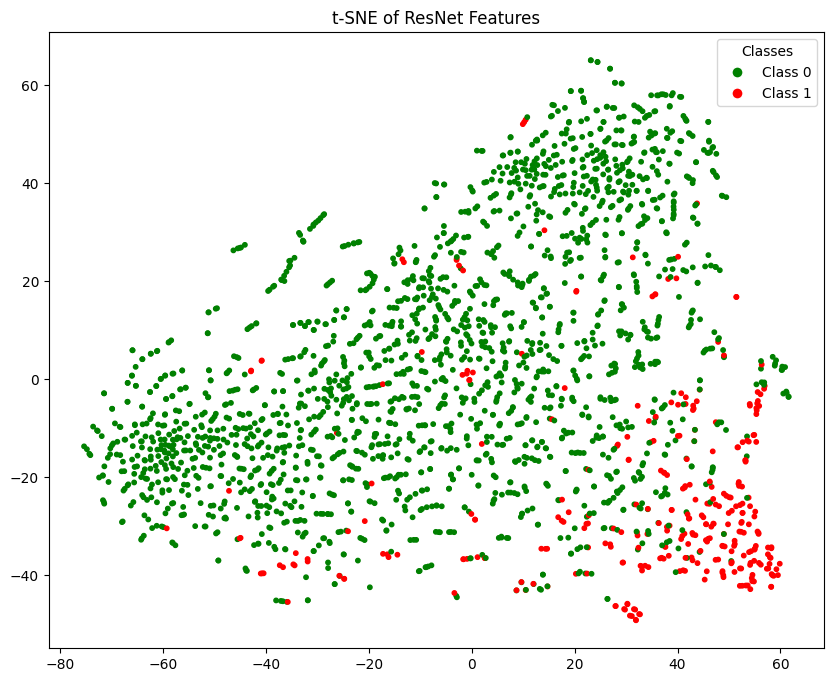

In [74]:
plotTSNE(features_reshaped, labels)

Clusters are slightly overlapping, with no foolproof way of aggregating some outliers. The t-SNE documentation recommends feature reduction to improve t-SNE quality. Let's try it out:


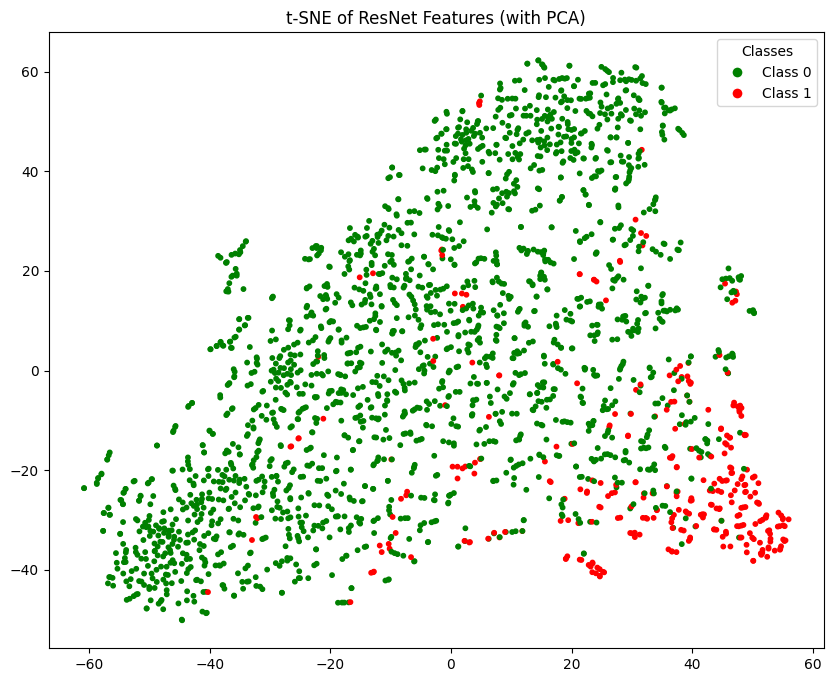

In [34]:
plotTSNE(features_reshaped, labels, apply_pca=True)

The next step is to classify test slices, based on feature proximity. It's important to compute real distances, and not t-SNE based distances due to its spatial distortion.

Let's visualize test points in the overall graphic distribution:

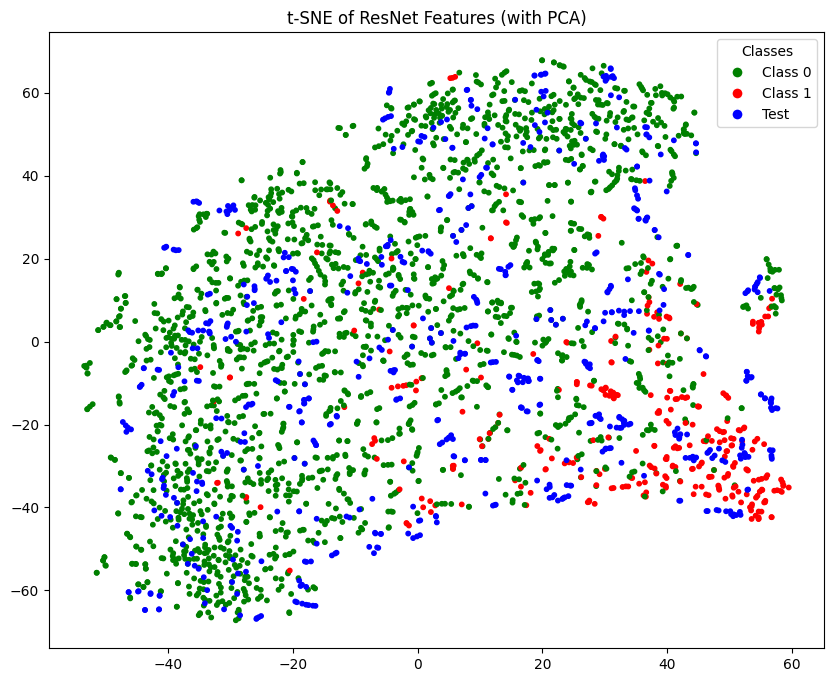

In [35]:
plotTSNE(features_reshaped, labels, test_features, apply_pca=True)

## Vector Proximity Criteria

First, I must evaluate different distance measures, in order to use as much information as possible, but because my values are actually tensors of size 512 (optionally 50, if using PCA to improve speeds), I must adapt even the simplest of distance functions.

### Euclidean Distance

Usually, we look at euclidean distance as if it were something along the lines of

$$
\text{dist} = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
$$

, but in this case, since there are 512 dimensions, it'd be more like


$$
\text{dist} = \sqrt{\sum_{i=1}^{512} (a_i - b_i)^2}
$$

### Cosine Distance (1 - Cosine Similarity)

Regarding cosine distance, we always think of

$$
\text{dist} = 1 - \frac{x_1y_1 + x_2y_2}{\sqrt{x_1^2 + x_2^2} \cdot \sqrt{y_1^2 + y_2^2}}
$$

, but in this case, since there are 512 dimensions, it'd be more like

$$
\text{dist} = 1 - \frac{\sum_{i=1}^{512} a_i b_i}{\sqrt{\sum_{i=1}^{512} a_i^2} \cdot \sqrt{\sum_{i=1}^{512} b_i^2}}
$$

In [36]:
def euclideanDistance(a, b):
    # Torch features normal distance for tensors, makes this quite easy
    return torch.norm(a - b)

def cosineDistance(a, b):
    # Torch functionalities also make this pretty straightforward
    cosine_similarity = F.cosine_similarity(a, b, dim=0)
    return 1 - cosine_similarity


### Mahalanobis

Finally, Mahalanobis distance is formally defined as

$$
\text{dist} = \sqrt{(x - \mu)^T \Sigma^{-1} (x - \mu)}
$$

, but in this case, since each element represents a collection of other elements instead of a singular value, I must make some adjustments:

 - **Distribution mean** == Each class centroid → Mean of all vectors in that class
 - **Distribution covariance** == Covariance of a matrix where rows are slices and columns are features

### <span style="color:red"> WARNING!!! </span>

Mahalanobis needs the distribution size to be of at least len(features) (512), in order to have a reversible covariance matrix (full rank).

In our case, class 1 displays only 324 examples. 

**`Introducing`**: **Ledoit-Wolf Shrinkage!** (Covariance Regularization)

In high-dimensional settings (when n_features > n_samples), the covariance matrix becomes unstable, potentially even non-invertible.
Ledoit-Wolf fixes this by "shrinking" the covariance toward a simpler, well-behaved matrix (a scaled identity matrix):

- Reduces noise and overfitting from high-dimensional data
- Balances bias vs. variance to improve numerical stability
- Always produces an invertible covariance matrix, even when n_samples < n_features

By adding Ledoit-Wolf to the computation, Mahalanobis will have access to a blended, regularized covariance matrix that's always safe to invert.

This'll prevent exploding or negative distances (found during initial testing) due to numerical instability.

In [37]:
def customMahalanobisDistance(x, X):     
    # Transform slice (x) and cluster (X == matrix of all slices) to np
    x, X = x.numpy(), torch.stack(X).numpy()

    # Calculate centroid of X
    centroid = np.mean(X, axis=0)

    if len(X) >= 512: 
        # Calculate covariance of X
        # It's important to set rowvar to False, otherwise
        # column == obs (slice)  | row == feature, which is the
        # inverse of what we need
        covariance_matrix = (np.cov(X, rowvar=False))
        inv_cov = np.linalg.inv(covariance_matrix)
    else: 
        # This implements LedoitWolf, so there's no need for
        # rowvar == False
        lw = LedoitWolf().fit(X)
        inv_cov = np.linalg.inv(lw.covariance_)
        

    # Compute values
    delta = (x-centroid)
    squared_dist = ((delta.T) @ inv_cov) @ (delta)
    #print(squared_dist)
    return math.sqrt(squared_dist)

The ROC concept applied in previous notebooks cannot be replicated here.

For that reason, the best "threshold", which is equivalent to the best K in K-NN, will be determined through brute force search.
Additionally, Mahalanobis distance can only be used when comparing distance to clusters, and not to individual K slices.

## Classifying Test Slices

**Disclaimer**: Since both training and validation `.csv`'s were created with the same class 1 to 0 proportion, their addition shares 0.133 to 0.867 proportion. This means that the weights for weighted accuracy remain the same.

### CPU Bound Code

Initially, this was done through CPU-bound loops. However, the exceedingly large execution time forced me to work in batches and use my GPU.

The FULL CPU logic can be found below, although only Mahalanobis is recommended here.

<br>
<center>

##### <i> <span style="color:red"> CPU execution runtime: ~1h!</span> </i>

</center>

In [38]:
def featuresKNN_CPU(train_val_features, labels, test_features, test_labels, criteria="euclidean",k=1):
    if k==0: return f"K CANNOT BE ZERO. SHUTTING DOWN..."
    if criteria not in ["euclidean", "cosine", "mahalanobis"]: 
        return f"INVALID DISTANCE CRITERIA. SHUTTING DOWN..."

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = test_labels
    y_pred = []

    # Needed for K-NN
    distances = []

    # Needed for Mahalanobis
    cluster0, cluster1 = [], []
    for i in range(len(train_val_features)):
        if labels[i] == 0: cluster0.append(train_val_features[i])
        else: cluster1.append(train_val_features[i])

    print(f"Length of class1: {len(cluster1)}")


    # Avoids loop and if-statement repetitiveness
    dist_func = {
        "euclidean": euclideanDistance,
        "cosine": cosineDistance,
        "mahalanobis": customMahalanobisDistance
    }

    description = f"Computing {criteria} distances"
    if criteria in ["euclidean", "cosine"]: description += f" for k=={k}... "
    else: description += f"... "
    
    for test_slice in tqdm(test_features, desc = description):
        # 1. Compute distances
        if criteria in ["euclidean", "cosine"]:
            for i in range(len(train_val_features)):
                train_slice, train_slice_label = train_val_features[i], labels[i]

                # Creates (distance, label) tuple for ranking and majority voting classification
                dist_pair = (dist_func[criteria](test_slice, train_slice), train_slice_label)
                distances.append(dist_pair)

            # Sorts distances in ascending order, making the 
            # first elements the closest to the slice 
            sorted_distances = sorted(distances, key=lambda x: x[0])

            # Creates ranking
            ranking = [sorted_distances[i][0] for i in range(k)]

            # 2.1. Classify slices based on k value

            # Gets classification based on majority voting:
            # number of ones in an array with only 1s and 0s == sum of every element,
            # if the sum represents at least half the elements, then it's fibrosis 
            # (rather assume it's fibrosis when not sure), 0 otherwise
            y_pred.append(1 if (np.sum(ranking) >= (len(ranking) / 2)) else 0)
            total +=1

        
        else:
            # Compute distances to each cluster centroid
            try:
                dist0 = dist_func[criteria](test_slice, cluster0)
                dist1 = dist_func[criteria](test_slice, cluster1)
            except Exception as e:    
                print(e)
            

            # 2.2. Classify slices based on centroid proximity
            y_pred.append(1 if dist1 <= dist0 else 0)
            total +=1


        
    # 3. Evaluate classifications
    # Class-specific accuracy
    for label, pred in zip(y_true, y_pred):
        if label == 0:
            total_class_0 += 1
            if pred == label:
                correct_class_0 += 1
                correct += 1
        elif label == 1:
            total_class_1 += 1
            if pred == label:
                correct_class_1 += 1
                correct += 1


    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")


    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

### GPU Code

This is the batch computed version. Mahalanobis has not been adapted due to acceptable runtime while using CPU.

<br>
<center>

##### <i> <span style="color:green"> GPU execution improved runtime from ~1h to ~240ms! </span> </i>

</center>

In [39]:
def euclideanDistance_batch(test_batch, train_batch):
    # test_batch: shape → [num_test, feat_dim]
    # train_batch: shape → [num_train, feat_dim]
    # Computes pairwise distances: output shape → [num_test, num_train]
    return torch.cdist(test_batch, train_batch, p=2)

def cosineDistance_batch(test_batch, train_batch):
    # Normalize first
    test_norm = F.normalize(test_batch, p=2, dim=1)
    train_norm = F.normalize(train_batch, p=2, dim=1)
    # Cosine similarity: shape → [num_test, num_train]
    sim = torch.matmul(test_norm, train_norm.T)
    return 1 - sim

In [40]:
def featuresKNN_GPU(train_val_features, labels, test_features, test_labels, criteria="euclidean",k=1, verbose=1):
    if k==0: return f"K CANNOT BE ZERO. SHUTTING DOWN..."
    if criteria not in ["euclidean", "cosine", "mahalanobis"]: 
        return f"INVALID DISTANCE CRITERIA. SHUTTING DOWN..."
    
    # Moves data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_val_features = torch.stack(train_val_features).to(device)
    labels = torch.tensor(labels).to(device)
    test_features = torch.stack(test_features).to(device)
    test_labels = torch.tensor(test_labels).to(device)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = test_labels
    y_pred = []

    # Needed for K-NN
    distances = []

    # Needed for Mahalanobis
    cluster0, cluster1 = [], []
    for i in range(len(train_val_features)):
        if labels[i] == 0: cluster0.append(train_val_features[i])
        else: cluster1.append(train_val_features[i])

    #print(f"Length of class1: {len(cluster1)}")

    dist_func = {
        "euclidean": euclideanDistance_batch,
        "cosine": cosineDistance_batch,
    }

    description = f"Computing {criteria} distances"
    if criteria in ["euclidean", "cosine"]: description += f" for k=={k}... "
    else: description += f"... "
    
    if criteria in ["euclidean", "cosine"]:
        # Distances between test and train: shape → [num_test, num_train]
        distances = dist_func[criteria](test_features, train_val_features)  

        # For each array of elements dist(test_slice, train_val_slice), 
        # pulls indexes of the smallest values. 
        topk_indices = torch.topk(distances, k=k, largest=False, dim=1).indices  # shape → [num_test, k]

        # Since labels and train_val_features are index-synchronized,
        # the indexes can be used in label[index] to pull the classes of the closest examples
        neighbor_labels = labels[topk_indices]  # shape → [num_test, k]

        # Same concept as before, but uses dim=1 to sum only
        # along the rows (each array of labels!)
        vote_sums = neighbor_labels.sum(dim=1)

        # Finally, applies majority voting, using .long()
        # to convert False and True to 0s and 1s, respectively
        predictions = (vote_sums >= (k / 2)).long()  # shape → [num_test]
        
        y_pred = predictions.tolist()
        total = len(test_features)

    # Class-specific accuracy
    for label, pred in zip(y_true, y_pred):
        if label == 0:
            total_class_0 += 1
            if pred == label:
                correct_class_0 += 1
                correct += 1
        elif label == 1:
            total_class_1 += 1
            if pred == label:
                correct_class_1 += 1
                correct += 1

    # Moving data to cpu
    y_true = y_true.cpu().numpy() if torch.is_tensor(y_true) else np.array(y_true)
    y_pred = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else np.array(y_pred)

    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    #print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    if verbose==0: return k, weighted_accuracy/100, f1_weighted


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")


    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

The average runtime improved drastically. You can find a table displaying overall execution times realtive to the number of `k`'s tested:

<center>

| `k`     | ~ CPU Time| ~ GPU Time      |  CPU Issues                                   |
| ------- | -------- | --------------- | ---------------------------------------------- |
| **1**   | 1h       | 0.240s     |  *Feasible on both CPU and GPU*                |
| **10**  | 10h      | 0.3s       |  *Barely feasible on CPU*                      |
| **100** | 100h     | 1.2s       |  *Impractical on CPU*                          |
| **200** | 200h     | 5s         |  *Highly constraining on CPU*                  |
| **300** | 300h     | 30s        |  *Unusable on CPU without parallelization*     |
| **400** | 400h     | 2m         |  *Completely infeasible on CPU*                |
| **500** | 500h     | 5m         |  *CPU run is practically impossible*           |

</center>

## Distance Functions Performance

In [41]:
def distanceCriteriaEvolution(k_list, acc_list, f1_list):
    combined_score = (np.array(acc_list) + np.array(f1_list)) / 2
    best_k_index = np.argmax(combined_score)
    best_k = k_list[best_k_index]

    plt.figure(figsize=(10, 5))
    plt.plot(k_list, acc_list, label='Weighted Accuracy', color='blue')
    plt.plot(k_list, f1_list, label='Weighted F1 Score', color='green')
    plt.plot(k_list, combined_score, label='Combined Score', linestyle='--', color='orange')
    plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')

    plt.xlabel('k')
    plt.ylabel('Normalized Score')
    plt.title('KNN Performance Evolution with k')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Euclidean Performance

Testing for best k...: 100%|██████████| 512/512 [03:30<00:00,  2.44it/s]


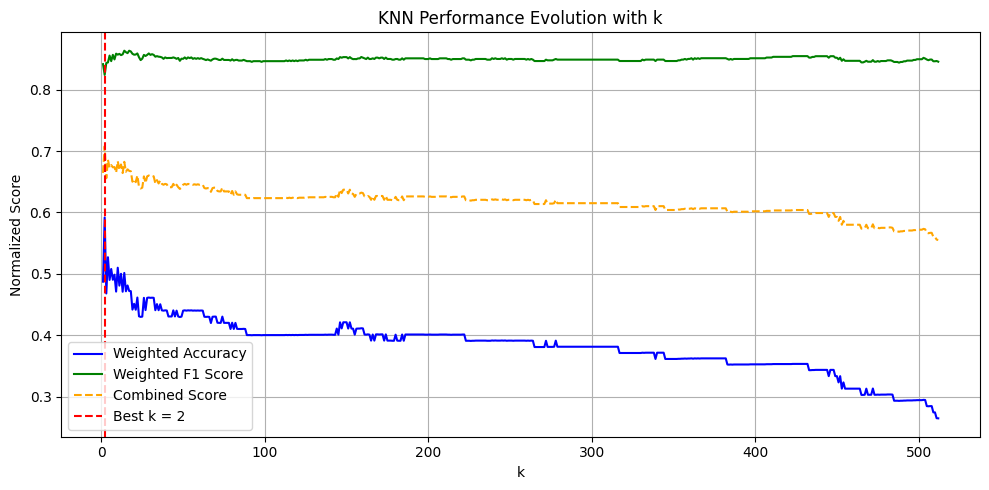

In [42]:
k_list_euclid, w_acc_list_euclid, w_f1_list_euclid = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=i,verbose=0)
    k_list_euclid.append(k_i)
    w_acc_list_euclid.append(weighted_acc_i)
    w_f1_list_euclid.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_euclid, w_acc_list_euclid, w_f1_list_euclid)

In [43]:
print("                            Eucliean Distance Performance for k=2                            ")
featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="euclidean",k=2)

                            Eucliean Distance Performance for k=2                            

 --------------------- 

Accuracy for Class 0: 84.55%  (476 in 563)
Accuracy for Class 1: 55.29%  (47 in 85)
Test Accuracy: 80.71%
Weighted Accuracy: 59.18%

 --------------------- 

F1 Score (Macro): 0.657
F1 Score (Weighted): 0.824
F1 Score Class 0: 0.884
F1 Score Class 1: 0.429

 --------------------- 


Confusion Matrix: 
 [[476  87]
 [ 38  47]]


### Cosine Performance

Testing for best k...: 100%|██████████| 512/512 [03:01<00:00,  2.83it/s]


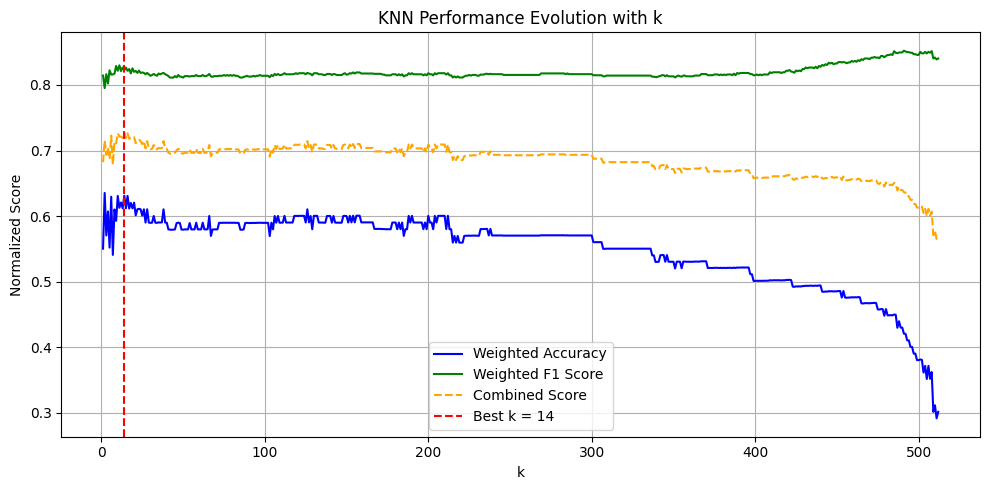

In [44]:
k_list_cosine, w_acc_list_cosine, w_f1_list_cosine = [], [], []
for i in tqdm(range(1,513), desc= "Testing for best k..."):
    k_i, weighted_acc_i, weighted_f1_i = featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels, criteria="cosine",k=i,verbose=0)
    k_list_cosine.append(k_i)
    w_acc_list_cosine.append(weighted_acc_i)
    w_f1_list_cosine.append(weighted_f1_i)

distanceCriteriaEvolution(k_list_cosine, w_acc_list_cosine, w_f1_list_cosine)

In [45]:
print("                            Cosine Distance Performance for k=8                            ")
featuresKNN_GPU(features_reshaped, labels, test_reshaped, test_labels,criteria="cosine",k=8)

                            Cosine Distance Performance for k=8                            

 --------------------- 

Accuracy for Class 0: 82.95%  (467 in 563)
Accuracy for Class 1: 57.65%  (49 in 85)
Test Accuracy: 79.63%
Weighted Accuracy: 61.01%

 --------------------- 

F1 Score (Macro): 0.651
F1 Score (Weighted): 0.817
F1 Score Class 0: 0.876
F1 Score Class 1: 0.426

 --------------------- 


Confusion Matrix: 
 [[467  96]
 [ 36  49]]


### Mahalanobis Performance

In [46]:
featuresKNN_CPU(features_reshaped, labels, test_reshaped, test_labels,criteria="mahalanobis")

Length of class1: 324


Computing mahalanobis distances... : 100%|██████████| 648/648 [01:51<00:00,  5.83it/s]

Total examples: 648

 --------------------- 

Accuracy for Class 0: 91.83%  (517 in 563)
Accuracy for Class 1: 36.47%  (31 in 85)
Test Accuracy: 84.57%
Weighted Accuracy: 43.83%

 --------------------- 

F1 Score (Macro): 0.647
F1 Score (Weighted): 0.842
F1 Score Class 0: 0.912
F1 Score Class 1: 0.383

 --------------------- 


Confusion Matrix: 
 [[517  46]
 [ 54  31]]


---

# EXTRA: Visualizing Different Manifestations

## Concept Overview

Due to discrepancies in clusters, identifiable outliers are always assumed to belong to the fibrosis class. However, it is also worth mentioning that the fibrosis class encompasses `early_fibrosis`, `bronchiectasis` and `reticulation`.

After identifying that the model was consistently underperforming in class 1, I initially attributed this issue to outliers in the t-SNE plot. Through further analysis, it's easy to understand that this could not be happening, since I always assume majority voting ties belong to the fibrosis class (in the real world, it would be better to always assume they are sick rather then not, which would then justify the need for further testing). If assuming different manifestations as fibrosis were, in fact, hindering classification, then **class 1 would be over-classified, and not the other way around**, as I am simply encouraging the model (in this case, proximity clusters) to assume fibrosis presence.

As a sanity check, I'll dedicate this subsection to the visualization (and possibly new result assessment) of separate manifestations as fibrosis. I'll be working on ways to eliminate assumption, such as considering anything other than fibrosis to belong to class 0, comparing result performance. 

The main goal is to understand how close some slices are to being identified as healthy, when observing them in a t-SNE, distorted space context. It does not mean that patients are actually healthy, but simply rearranging outliers can change cluster shapes and proximities, potentially improving model correctness and performance.

## Fetching Slice Information

The code below will help me find the slices with different manifestations of fibrosis, through parsing of `.txt` ROI files. It can detect all 3 aforementioned aggregated manifestations, and return the folder in which they were found, as well as the indexes of the slices with said manifestation:

In [47]:
import os
import re

root = r"..\\..\\..\\fibrosis_dataset\ILD_DB_txtROIs"

In [48]:
def load_roi_files(roi_file_name):
    # List to store all the ROIs
    rois = []

    # Open the ROI file for reading
    with open(roi_file_name, 'r') as file:
        roi = {}
        while True:
            # Read a line from the file
            line = file.readline()
            
            # Stop if we reach the end of the file
            if not line:
                break

            # Check and parse each line based on its prefix
            if 'label:' in line:
                roi['label'] = line.replace('label: ', '').strip()
            elif 'slice_number:' in line:
                roi['slice_number'] = float(line.replace('slice_number: ', '').strip())

                # Append the parsed ROI to the list of ROIs
                rois.append(roi)
                roi = {}  # Reset for the next ROI

    return rois

In [49]:
def searchDiffManifest(folder, verbose=1):

    target_labels = {"early_fibrosis", "bronchiectasis", "reticulation"}
    manifest_dict = {label: {} for label in target_labels}
    ctr=0

    for root, dirs, files in os.walk(folder):
        folder_name = os.path.basename(root)

        for file in files:
            if not file.endswith(".txt"):
                continue

            txt_file_path = os.path.join(root, file)
            rois = load_roi_files(txt_file_path)

            if not rois or not isinstance(rois[0], dict):
                continue

            if verbose == 1:
                first_label = rois[0].get('label', None)
                if first_label in target_labels:
                    print(f"Searching in folder: {folder_name}")
                    print(f"{file}\n")
                    for d in rois:
                        print(d)
                        for key in d.keys(): 
                            if "slice_number" in key: ctr+=1
                    print("\n" + "="*50 + "\n\n")
            else:
                current_label = None
                for roi in rois:
                    if 'label' in roi and roi['label'] in target_labels:
                        current_label = roi['label']

                    if current_label and 'slice_number' in roi:
                        slice_num = int(roi['slice_number'])

                        # Insert into correct dictionary
                        if folder_name not in manifest_dict[current_label]:
                            manifest_dict[current_label][folder_name] = []

                        manifest_dict[current_label][folder_name].append(slice_num)

    if verbose != 1:
        return manifest_dict

    print(ctr)


In [50]:
searchDiffManifest(root)

Searching in folder: 107
CT-INSPIRIUM-3684.txt

{'label': 'reticulation', 'slice_number': 12.0}
{'slice_number': 13.0}
{'slice_number': 14.0}
{'slice_number': 15.0}
{'slice_number': 16.0}
{'slice_number': 17.0}
{'slice_number': 18.0}
{'slice_number': 19.0}
{'label': 'ground_glass', 'slice_number': 11.0}
{'slice_number': 12.0}
{'slice_number': 15.0}



Searching in folder: 108
CT-INSPIRIUM-6415.txt

{'label': 'reticulation', 'slice_number': 18.0}
{'slice_number': 19.0}
{'slice_number': 20.0}
{'slice_number': 21.0}
{'label': 'ground_glass', 'slice_number': 9.0}
{'slice_number': 10.0}
{'slice_number': 11.0}
{'slice_number': 13.0}



Searching in folder: 128
CT-Thx-HR-1-10-mm-inspiration-0007.txt

{'label': 'reticulation', 'slice_number': 22.0}
{'slice_number': 23.0}
{'slice_number': 24.0}
{'slice_number': 25.0}
{'slice_number': 26.0}
{'slice_number': 29.0}
{'slice_number': 30.0}
{'slice_number': 31.0}
{'slice_number': 32.0}
{'slice_number': 33.0}
{'slice_number': 34.0}
{'slice_number': 35

Now that we have seen the parsing process, I can change it so that it fits our main purpose:

In [51]:
annotations_file_train = r"..\trainTestCustom\train.csv"
annotations_file_val = r"..\trainTestCustom\val.csv"

train_ds = pd.read_csv(annotations_file_train)
val_ds = pd.read_csv(annotations_file_val)

manifest_dict = searchDiffManifest(root,verbose=0)

This will allow me to use the current data split dataframe, and extract each relevant `SliceID`, placing them into a new, custom dataframe:

In [54]:
def manifestationDataframe(manifest_dict, df):

    full_df = df
    result_rows = []
    slice_manifestation_map = {}  # To track manifestations per sliceID

    # Step 2: Iterate through manifestations and patients
    for manifestation, patients in manifest_dict.items():
        for folder_name, slice_indexes in patients.items():
            pseudo_patient_id = folder_name + "_"

            # Step 2.1: Get all rows matching the pseudo_patient_id
            matching_rows = full_df[full_df["SliceID"].str.contains(pseudo_patient_id, na=False)]


            if matching_rows.empty:
                print(f"⚠️ Warning: Folder '{folder_name}' not found in datasets.")
                continue

            # Matching rows are sequential 
            matching_rows = matching_rows.reset_index(drop=True)

            # Step 2.1.1: Convert slice indexes to row indexes (slice_number - 1)
            target_indexes = set(s - 1 for s in slice_indexes)

            filtered_rows = [
                row for i, row in matching_rows.iterrows()
                if i in target_indexes
            ]


            # Step 2.2: Add each match to the result list and track manifestations
            for row in filtered_rows:
                slice_id = row["SliceID"]
                if slice_id not in slice_manifestation_map:
                    slice_manifestation_map[slice_id] = set()

                # Check if slice already has manifestations
                if slice_manifestation_map[slice_id] and manifestation not in slice_manifestation_map[slice_id]:
                    existing = slice_manifestation_map[slice_id]
                    print(f"⚠️ Warning: SliceID '{slice_id}' has multiple manifestations: {existing} + '{manifestation}'")

                slice_manifestation_map[slice_id].add(manifestation)

                result_rows.append({
                    "SliceID": slice_id,
                    "Manifestation": manifestation
                })

    # Step 3: Return result as a DataFrame
    return pd.DataFrame(result_rows)


In [55]:
full_df = pd.concat([train_ds, val_ds], ignore_index=True)

manifest_df = manifestationDataframe(manifest_dict, full_df)

⚠️ Warning: Folder '12' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8871' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-8873' not found in datasets.
⚠️ Warning: Folder '108' not found in datasets.
⚠️ Warning: Folder '150' not found in datasets.
⚠️ Warning: Folder '155' not found in datasets.
⚠️ Warning: Folder '157' not found in datasets.


Some folder were not foun in the train + validation dataframe. If everything was done correctly, then all of the folders above must be present in the test dataframe:

In [56]:
annotations_file_test = r"..\trainTestCustom\test.csv"

test_ds = pd.read_csv(annotations_file_test)

manifest_df_test = manifestationDataframe(manifest_dict, test_ds)

⚠️ Warning: Folder 'CT-INSPIRIUM-2951' not found in datasets.
⚠️ Warning: Folder '21' not found in datasets.
⚠️ Warning: Folder '46' not found in datasets.
⚠️ Warning: Folder 'CT-INSPIRIUM-3550' not found in datasets.
⚠️ Warning: Folder '90' not found in datasets.
⚠️ Warning: Folder '204' not found in datasets.
⚠️ Warning: Folder '207' not found in datasets.
⚠️ Warning: Folder '208' not found in datasets.
⚠️ Warning: Folder '107' not found in datasets.
⚠️ Warning: Folder '128' not found in datasets.
⚠️ Warning: Folder '177' not found in datasets.
⚠️ Warning: Folder '179' not found in datasets.
⚠️ Warning: Folder '181' not found in datasets.
⚠️ Warning: Folder '46' not found in datasets.
⚠️ Warning: Folder '165' not found in datasets.


Now each warning identifies all cases present in the train_val dataframe, which is a good indicator that everything was correctly computed.

## New t-SNE Plots

In [58]:
def plotTSNEManifest(train_val_features, train_val_labels, test_features=False, full_df=False, manifest_df=False, apply_pca=False, mask=False):
    X_train_val = torch.stack(train_val_features).cpu().numpy()
    y_train_val = np.array(train_val_labels)

    if manifest_df is not False:
        for _, row in manifest_df.iterrows():
            slice_id = row["SliceID"]
            manifestation = row["Manifestation"]
            match_idx = full_df[full_df["SliceID"] == slice_id].index
            if not match_idx.empty:
                idx = match_idx[0]
                if y_train_val[idx] == 1:
                    if manifestation == "early_fibrosis":
                        y_train_val[idx] = 3
                    elif manifestation == "bronchiectasis":
                        y_train_val[idx] = 4
                    elif manifestation == "reticulation":
                        y_train_val[idx] = 5
                else: print(f"{slice_id} is not class 1!!!")

    X, y = X_train_val, y_train_val

    if test_features is not False:
        X_test = torch.stack([f.view(-1) for f in test_features], dim=0).cpu().numpy()
        y_test = np.full(len(X_test), 2)               

        X = np.concatenate((X_train_val, X_test), axis=0)
        y = np.concatenate((y_train_val, y_test), axis=0)
    

    if apply_pca:
        pca = PCA(n_components=50)
        X = pca.fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    # Assign colors for original plot
    base_colors = np.array([
        'green' if label == 0 else
        'red' if label in [1, 3, 4, 5] else
        'blue' if label == 2 else
        'teal' for label in y
    ])

    # Assign extended colors for manifestation plot
    extended_colors = np.array([
        'green' if label == 0 else
        'red' if label == 1 else
        'blue' if label == 2 else
        'violet' if label == 3 else
        'purple' if label == 4 else
        'maroon' for label in y
    ])


    if not mask:
        # Plot side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # Left: Original
        axes[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=base_colors, s=10)
        axes[0].set_title("t-SNE of ResNet Features (Original)")
        base_legend = [
            Line2D([0], [0], marker='o', color='w', label='Class 0', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Class 1', markerfacecolor='red', markersize=8)
        ]
        if test_features is not False:
            base_legend.append(Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='blue', markersize=8))
        axes[0].legend(handles=base_legend, title="Classes")

        # Right: With manifestations
        axes[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=extended_colors, s=10)
        axes[1].set_title("t-SNE with Manifestations")

        ext_legend = [
            Line2D([0], [0], marker='o', color='w', label='Healthy (0)', markerfacecolor='green', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Fibrosis (1)', markerfacecolor='red', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Early Fibrosis (3)', markerfacecolor='violet', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Bronchiectasis (4)', markerfacecolor='purple', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Reticulation (5)', markerfacecolor='maroon', markersize=8),
        ]
        axes[1].legend(handles=ext_legend, title="Detailed Classes")

        if test_features is not False: 
            ext_legend.append(Line2D([0], [0], marker='o', color='w', label='Test (2)', markerfacecolor='blue', markersize=8))
    
    else:
        # Split into two groups: fibrosis (1) and manifestations (3, 4, 5)
        fibrosis_only_mask = (y == 1)
        manifestations_only_mask = np.isin(y, [3, 4, 5])

        X_fibrosis = X_embedded[fibrosis_only_mask]
        y_fibrosis = y[fibrosis_only_mask]

        X_manifestations = X_embedded[manifestations_only_mask]
        y_manifestations = y[manifestations_only_mask]

        # Assign colors
        fibrosis_colors = ['red' for _ in y_fibrosis]
        manifestation_colors = [
            'violet' if label == 3 else
            'purple' if label == 4 else
            'maroon' for label in y_manifestations
        ]

        # First plot: Fibrosis only
        plt.figure(figsize=(8, 6))
        plt.scatter(X_fibrosis[:, 0], X_fibrosis[:, 1], c=fibrosis_colors, s=10)
        plt.title("t-SNE: Fibrosis Only (Label 1)")
        plt.legend(handles=[
            Line2D([0], [0], marker='o', color='w', label='Fibrosis (1)', markerfacecolor='red', markersize=8)
        ], title="Class")
        plt.tight_layout()
        plt.show()

        # Second plot: Manifestations only
        plt.figure(figsize=(8, 6))
        plt.scatter(X_manifestations[:, 0], X_manifestations[:, 1], c=manifestation_colors, s=10)
        plt.title("t-SNE: Manifestations Only (Labels 3, 4, 5)")
        plt.legend(handles=[
            Line2D([0], [0], marker='o', color='w', label='Early Fibrosis (3)', markerfacecolor='violet', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Bronchiectasis (4)', markerfacecolor='purple', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Reticulation (5)', markerfacecolor='maroon', markersize=8),
        ], title="Manifestations")


    plt.tight_layout()
    plt.show()

121__CT-0844-0010.npy is not class 1!!!
107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!


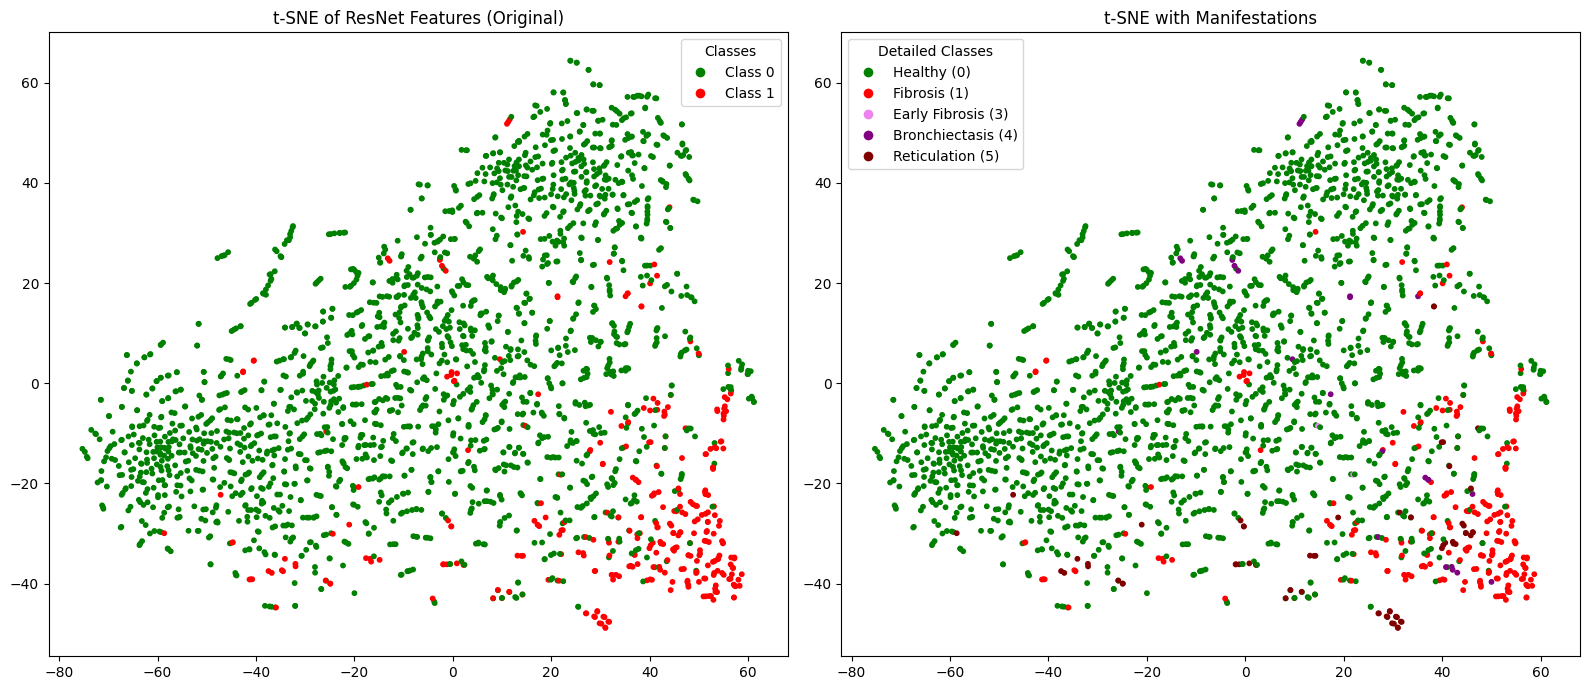

In [75]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False)

#### <span style="color:red"> WARNING!!! </span>

It seems that either my original data creation loop missed a few occurrences, or this new loop is incorrectly parsing them.

Due to the reduced number of issues, coupled with their relevance to the problem and remaining internship time frame, I will be ignoring them.

However, it is worth mentioning that they could be misleading the model, even if just for a small ammout. For this reason, I will not be plotting them as the new parser's identified manifestations, as they are never used as fibrosis in any other context.

# <span style="color:red"> Check with professors!!! </span>

 - if these slices are actualy very clearly sick lungs, they may be hindering model performance. manual check is feasible for only 8 slices.

This does help identifying that some outliers are in fact not fibrosis, but it would be better to simply create a sort of **mask**, showing only fibrosis and extra manifestations, in order to ascertain whether they represent the majority of distribution outliers.

121__CT-0844-0010.npy is not class 1!!!
107__CT-3684-0011.npy is not class 1!!!
181__CT-3207-0013.npy is not class 1!!!
181__CT-3207-0014.npy is not class 1!!!
181__CT-3207-0017.npy is not class 1!!!
181__CT-3207-0019.npy is not class 1!!!
181__CT-3207-0021.npy is not class 1!!!
181__CT-3207-0022.npy is not class 1!!!


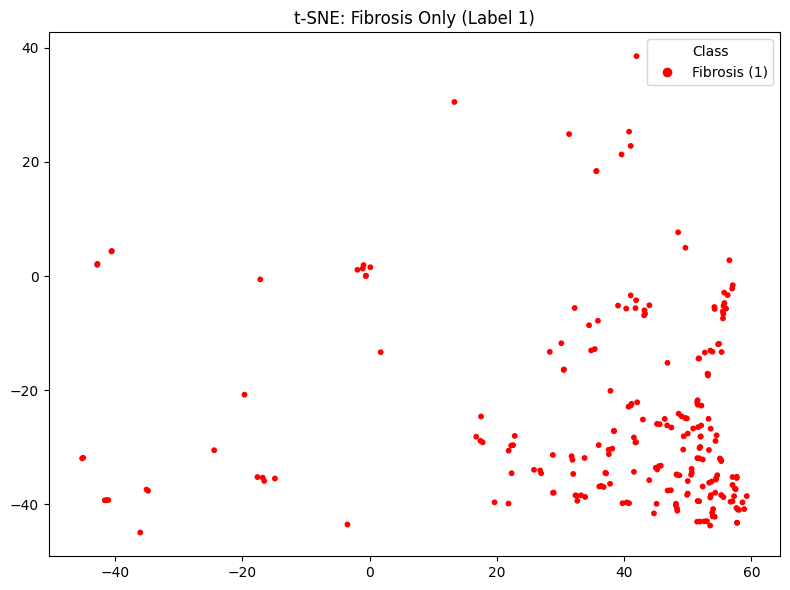

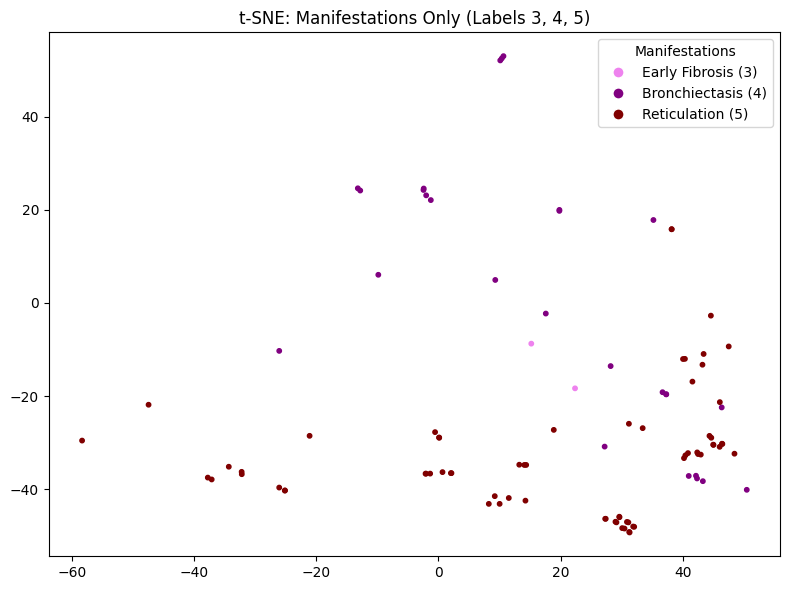

In [76]:
plotTSNEManifest(train_val_features=features_reshaped, 
                 train_val_labels=labels,
                 test_features=False, 
                 full_df=full_df, manifest_df=manifest_df, 
                 apply_pca=False, mask=True)

This shows that some outliers are in fact represented by the extra manifestations. However, the fibrosis class also follows a similar distribution, meaning that they were actually similar enough to be considered the same class, and are most likely **not the reason the model is underperforming in Class 1**.